# Итоговая аттестация по курсу “Профессия ML-инженер”
## "Распознавание действий на  видео с использованием 3D-CNNS"
- В данном блокноте код связанный с тренировкой модели;
- Работоспособность можно оценить по ссылке: https://huggingface.co/spaces/aquarapax/total_work;
- Для запуска в Google Colab раскоментируйте первые две строки с кодом.

In [1]:
# Установка библиотек в колабе 
# !pip install gdown # !!!!!!Раскоментируйте при запуске в Colab!!!!!!

In [2]:
# Загрузка датасета в колабе
# !gdown --id 1XceF3l0Zj1gSd4676fTqKk63El3VE5m- -O UCF101.zip # !!!!!!Раскоментируйте при запуске в Colab!!!!!!

### Импорт необходимых библиотек

In [3]:
# Импорт необходимых библиотек
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.video import r3d_18, R3D_18_Weights
from tqdm import tqdm
import numpy as np
from torch.cuda.amp import GradScaler, autocast
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import zipfile
import tempfile

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# SEED для воспроизводимости
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

Используемое устройство: cuda


### Конфигурация

In [4]:
class Config:
    DATA_PATH = "UCF101.zip"
    CLIP_LEN = 16
    FRAME_SIZE = 112
    BATCH_SIZE = 32
    EPOCHS = 50
    LR = 0.0001
    NUM_WORKERS = 0
    PATIENCE = 5
    MIN_LR = 0.0000001

### Класс DataSet

In [5]:
class Dataset(Dataset):
    def __init__(self, video_paths, labels):
        '''Инициализация'''
        self.video_paths = video_paths
        self.labels = labels
        # Конвертация в тензор нормализация
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # Открытие архива
        self.zip_ref = zipfile.ZipFile(Config.DATA_PATH, 'r')

    def __len__(self):
        '''Кол-во видео в датасете'''
        return len(self.video_paths)

    def __getitem__(self, idx):
        '''Загрузка и обрабатка видео по заданному индексу'''
        try:
            video_path = self.video_paths[idx]
            # открытие видео из zip-архива
            with self.zip_ref.open(video_path) as video_file:
                video_data = video_file.read()
                
                # Временный файл для видео
                temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.avi')
                temp_file.write(video_data)
                temp_file.close()
                
                # Открытие видео с помощью OpenCV
                cap = cv2.VideoCapture(temp_file.name)
                frames = []
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                skip = max(1, total_frames // Config.CLIP_LEN) # Шаг
                
                # Чтение кадров
                for i in range(Config.CLIP_LEN * skip):
                    ret, frame = cap.read()
                    if not ret:
                        break
                    if i % skip == 0:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frame = cv2.resize(frame, (Config.FRAME_SIZE, Config.FRAME_SIZE))
                        frames.append(frame)
                        if len(frames) == Config.CLIP_LEN:
                            break
                
                # "Падинг" кадров до CLIP_LEN
                while len(frames) < Config.CLIP_LEN:
                    frames.append(frames[-1] if frames else np.zeros((Config.FRAME_SIZE, Config.FRAME_SIZE, 3), dtype=np.uint8))
                
                cap.release()
                os.unlink(temp_file.name)
                # Преобразование кадров и формирование тензора
                return torch.stack([self.transform(f) for f in frames]), self.labels[idx]
            
        except Exception as e:
            print(f"Ошибка загрузки видео: {e}")
            # Нулевой тензор при ошибке
            dummy = torch.zeros((Config.CLIP_LEN, 3, Config.FRAME_SIZE, Config.FRAME_SIZE))
            return dummy, 0

### Модель

In [6]:
def load_model():
    """Загрузка предобученной модели R3D-18"""
    print("\nЗагрузка модели R3D-18...")
    try:
        # Загрузка модели с предобученными весами (KINETICS400_V1)
        model = r3d_18(weights=R3D_18_Weights.KINETICS400_V1)
        print("Модель успешно загружена с предобученными весами")
    except Exception as e:
        print(f"Ошибка загрузки весов: {e}")
        print("Инициализация модели без весов")
        model = r3d_18(weights=None)
    
    # Замена последнего слоя
    model.fc = nn.Linear(model.fc.in_features, 101)
    
    # Заморозка слоев
    for name, param in model.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False

    return model.to(device)

### Функция валидации

In [7]:
@torch.no_grad()
def evaluate(model, loader):
    """Оценка модели на валидационном наборе"""
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    for clips, labels in tqdm(loader, desc="Validation"):
        clips = clips.to(device)
        labels = labels.to(device)
        
        outputs = model(clips.permute(0, 2, 1, 3, 4))
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total, val_loss / len(loader)

### Тренировка

In [8]:
def train():
    if not os.path.exists(Config.DATA_PATH):
        raise FileNotFoundError(f"Архив {Config.DATA_PATH} не найден!")
    
    # Открытие zip-архива
    with zipfile.ZipFile(Config.DATA_PATH, 'r') as zip_ref:
        classes = sorted({os.path.dirname(f.filename) for f in zip_ref.infolist() if not f.is_dir()})
        
        # Словарь для преобразования имени класса в индекс
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        
        # Сбор путей к видеофайлам и соответствующие метки классов
        video_paths, labels = [], []
        for cls in classes:
            for f in zip_ref.infolist():
                if f.filename.startswith(cls + '/') and not f.is_dir():
                    video_paths.append(f.filename)
                    labels.append(class_to_idx[cls])
    
    # Разделение на trai и val
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        video_paths, labels, test_size=0.2, random_state=SEED)
    
    # Датасеты
    train_dataset = Dataset(train_paths, train_labels)
    val_dataset = Dataset(val_paths, val_labels)
    
    # Даталоадеры
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS
    )
    
    # Инициализация модели и параметры обучения
    model = load_model()
    optimizer = optim.Adam(model.parameters(), lr=Config.LR)
    scaler = GradScaler()
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience=2, min_lr=Config.MIN_LR)
    best_val_acc = 0
    epochs_no_improve = 0
    train_loss_history = []
    train_acc_history = []
    val_acc_history = []
    val_loss_history = []
    
    print(f"Начало обучения...")
    # Цикл обучения по эпохам
    for epoch in range(Config.EPOCHS):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        start_time = time.time()
        
        # Итерация по батчам
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}")
        for clips, labels in progress:
            clips = clips.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(clips.permute(0, 2, 1, 3, 4))
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{100.*correct/total:.1f}%"
            })
        
        val_acc, val_loss = evaluate(model, val_loader)
        scheduler.step(val_acc)
        
        train_loss_history.append(epoch_loss/len(train_loader))
        train_acc_history.append(100.*correct/total)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)
        
        print(f"Epoch {epoch+1} | Loss: {train_loss_history[-1]:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc_history[-1]:.2f}% | Val Acc: {val_acc:.2f}% | "
              ) 
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= Config.PATIENCE:
                print(f"\nРанняя остановка: нет улучшения {Config.PATIENCE} эпох подряд")
                break
    # Возврат метрик
    return train_loss_history, train_acc_history, val_acc_history, val_loss_history

### Запуск обучения

In [9]:
# Запуск обучения
torch.cuda.empty_cache()
train_loss, train_acc, val_acc, val_loss = train()


Загрузка модели R3D-18...


C:\Users\21693\AppData\Local\Temp\ipykernel_14980\2173883128.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Модель успешно загружена с предобученными весами
Начало обучения...


Epoch 1/50:   0%|          | 0/333 [00:00<?, ?it/s]C:\Users\21693\AppData\Local\Temp\ipykernel_14980\2173883128.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 84/84 [02:47<00:00,  1.99s/it]


Epoch 1 | Loss: 4.1431 | Val Loss: 3.5541 | Train Acc: 18.53% | Val Acc: 46.25% | 


Validation: 100%|██████████| 84/84 [02:44<00:00,  1.96s/it]


Epoch 2 | Loss: 3.1589 | Val Loss: 2.6749 | Train Acc: 59.08% | Val Acc: 68.73% | 


Validation: 100%|██████████| 84/84 [02:40<00:00,  1.91s/it]


Epoch 3 | Loss: 2.4083 | Val Loss: 2.0451 | Train Acc: 75.00% | Val Acc: 78.04% | 


Validation: 100%|██████████| 84/84 [02:43<00:00,  1.95s/it]


Epoch 4 | Loss: 1.8771 | Val Loss: 1.5993 | Train Acc: 81.99% | Val Acc: 82.02% | 


Validation: 100%|██████████| 84/84 [02:46<00:00,  1.99s/it]


Epoch 5 | Loss: 1.5115 | Val Loss: 1.3203 | Train Acc: 85.28% | Val Acc: 85.44% | 


Validation: 100%|██████████| 84/84 [02:39<00:00,  1.90s/it]


Epoch 6 | Loss: 1.2509 | Val Loss: 1.0865 | Train Acc: 88.11% | Val Acc: 87.88% | 


Validation: 100%|██████████| 84/84 [02:39<00:00,  1.90s/it]


Epoch 7 | Loss: 1.0677 | Val Loss: 0.9356 | Train Acc: 89.10% | Val Acc: 88.66% | 


Validation: 100%|██████████| 84/84 [02:36<00:00,  1.87s/it]


Epoch 8 | Loss: 0.9249 | Val Loss: 0.8278 | Train Acc: 90.39% | Val Acc: 89.45% | 


Validation: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]


Epoch 9 | Loss: 0.8161 | Val Loss: 0.7463 | Train Acc: 91.23% | Val Acc: 89.98% | 


Validation: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]


Epoch 10 | Loss: 0.7309 | Val Loss: 0.6732 | Train Acc: 91.84% | Val Acc: 90.62% | 


Validation: 100%|██████████| 84/84 [02:38<00:00,  1.88s/it]


Epoch 11 | Loss: 0.6571 | Val Loss: 0.6098 | Train Acc: 92.38% | Val Acc: 91.29% | 


Validation: 100%|██████████| 84/84 [02:37<00:00,  1.87s/it]


Epoch 12 | Loss: 0.5934 | Val Loss: 0.5562 | Train Acc: 93.17% | Val Acc: 91.67% | 


Validation: 100%|██████████| 84/84 [02:52<00:00,  2.05s/it]


Epoch 13 | Loss: 0.5498 | Val Loss: 0.5214 | Train Acc: 93.39% | Val Acc: 92.04% | 


Validation: 100%|██████████| 84/84 [02:44<00:00,  1.96s/it]


Epoch 14 | Loss: 0.5057 | Val Loss: 0.4845 | Train Acc: 93.93% | Val Acc: 93.17% | 


Validation: 100%|██████████| 84/84 [02:45<00:00,  1.97s/it]


Epoch 15 | Loss: 0.4667 | Val Loss: 0.4524 | Train Acc: 94.45% | Val Acc: 92.98% | 


Validation: 100%|██████████| 84/84 [02:47<00:00,  1.99s/it]


Epoch 16 | Loss: 0.4340 | Val Loss: 0.4207 | Train Acc: 94.81% | Val Acc: 93.21% | 


Validation: 100%|██████████| 84/84 [02:39<00:00,  1.90s/it]


Epoch 17 | Loss: 0.4055 | Val Loss: 0.3994 | Train Acc: 95.05% | Val Acc: 93.54% | 


Validation: 100%|██████████| 84/84 [02:41<00:00,  1.92s/it]


Epoch 18 | Loss: 0.3787 | Val Loss: 0.3778 | Train Acc: 95.35% | Val Acc: 93.92% | 


Validation: 100%|██████████| 84/84 [02:38<00:00,  1.89s/it]


Epoch 19 | Loss: 0.3541 | Val Loss: 0.3641 | Train Acc: 95.69% | Val Acc: 93.77% | 


Validation: 100%|██████████| 84/84 [02:39<00:00,  1.89s/it]


Epoch 20 | Loss: 0.3366 | Val Loss: 0.3409 | Train Acc: 95.86% | Val Acc: 94.18% | 


Validation: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]


Epoch 21 | Loss: 0.3157 | Val Loss: 0.3210 | Train Acc: 96.37% | Val Acc: 94.56% | 


Validation: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]


Epoch 22 | Loss: 0.2967 | Val Loss: 0.3075 | Train Acc: 96.34% | Val Acc: 94.59% | 


Validation: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]


Epoch 23 | Loss: 0.2811 | Val Loss: 0.2959 | Train Acc: 96.33% | Val Acc: 94.89% | 


Validation: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]


Epoch 24 | Loss: 0.2659 | Val Loss: 0.2851 | Train Acc: 96.81% | Val Acc: 95.12% | 


Validation: 100%|██████████| 84/84 [02:40<00:00,  1.91s/it]


Epoch 25 | Loss: 0.2513 | Val Loss: 0.2762 | Train Acc: 97.03% | Val Acc: 94.63% | 


Validation: 100%|██████████| 84/84 [02:38<00:00,  1.88s/it]


Epoch 26 | Loss: 0.2421 | Val Loss: 0.2634 | Train Acc: 97.08% | Val Acc: 95.16% | 


Validation: 100%|██████████| 84/84 [02:38<00:00,  1.89s/it]


Epoch 27 | Loss: 0.2323 | Val Loss: 0.2517 | Train Acc: 97.24% | Val Acc: 95.68% | 


Validation: 100%|██████████| 84/84 [02:38<00:00,  1.89s/it]


Epoch 28 | Loss: 0.2220 | Val Loss: 0.2492 | Train Acc: 97.29% | Val Acc: 95.46% | 


Validation: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]


Epoch 29 | Loss: 0.2138 | Val Loss: 0.2354 | Train Acc: 97.32% | Val Acc: 95.68% | 


Validation: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]


Epoch 30 | Loss: 0.2017 | Val Loss: 0.2340 | Train Acc: 97.44% | Val Acc: 95.50% | 


Validation: 100%|██████████| 84/84 [02:38<00:00,  1.88s/it]


Epoch 31 | Loss: 0.1938 | Val Loss: 0.2292 | Train Acc: 97.85% | Val Acc: 95.72% | 


Validation: 100%|██████████| 84/84 [02:39<00:00,  1.90s/it]


Epoch 32 | Loss: 0.1898 | Val Loss: 0.2294 | Train Acc: 97.76% | Val Acc: 95.65% | 


Validation: 100%|██████████| 84/84 [02:39<00:00,  1.90s/it]


Epoch 33 | Loss: 0.1898 | Val Loss: 0.2260 | Train Acc: 98.00% | Val Acc: 95.80% | 


Validation: 100%|██████████| 84/84 [02:38<00:00,  1.89s/it]


Epoch 34 | Loss: 0.1888 | Val Loss: 0.2273 | Train Acc: 97.89% | Val Acc: 95.72% | 


Validation: 100%|██████████| 84/84 [02:38<00:00,  1.89s/it]


Epoch 35 | Loss: 0.1862 | Val Loss: 0.2282 | Train Acc: 98.00% | Val Acc: 95.46% | 


Validation: 100%|██████████| 84/84 [02:39<00:00,  1.90s/it]


Epoch 36 | Loss: 0.1866 | Val Loss: 0.2239 | Train Acc: 97.91% | Val Acc: 95.65% | 


Validation: 100%|██████████| 84/84 [02:39<00:00,  1.89s/it]


Epoch 37 | Loss: 0.1863 | Val Loss: 0.2260 | Train Acc: 97.96% | Val Acc: 95.68% | 


Validation: 100%|██████████| 84/84 [02:38<00:00,  1.88s/it]

Epoch 38 | Loss: 0.1860 | Val Loss: 0.2289 | Train Acc: 97.96% | Val Acc: 95.72% | 

Ранняя остановка: нет улучшения 5 эпох подряд


### Визуализация метрик

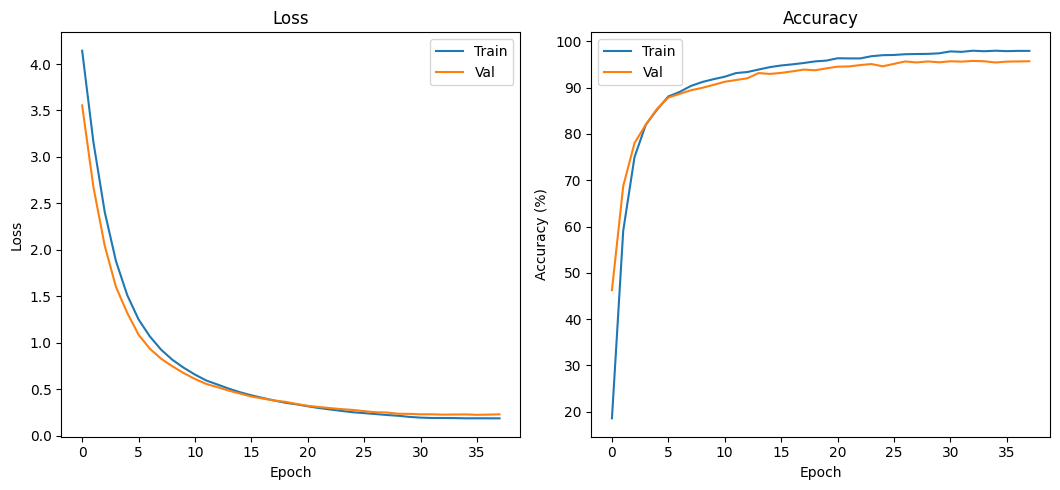

In [10]:
# Графики обучения
plt.figure(figsize=(16, 5))

# График потерь
plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 3, 2)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()


plt.tight_layout()
plt.show()

### Вывод примеров


Загрузка модели R3D-18...
Модель успешно загружена с предобученными весами


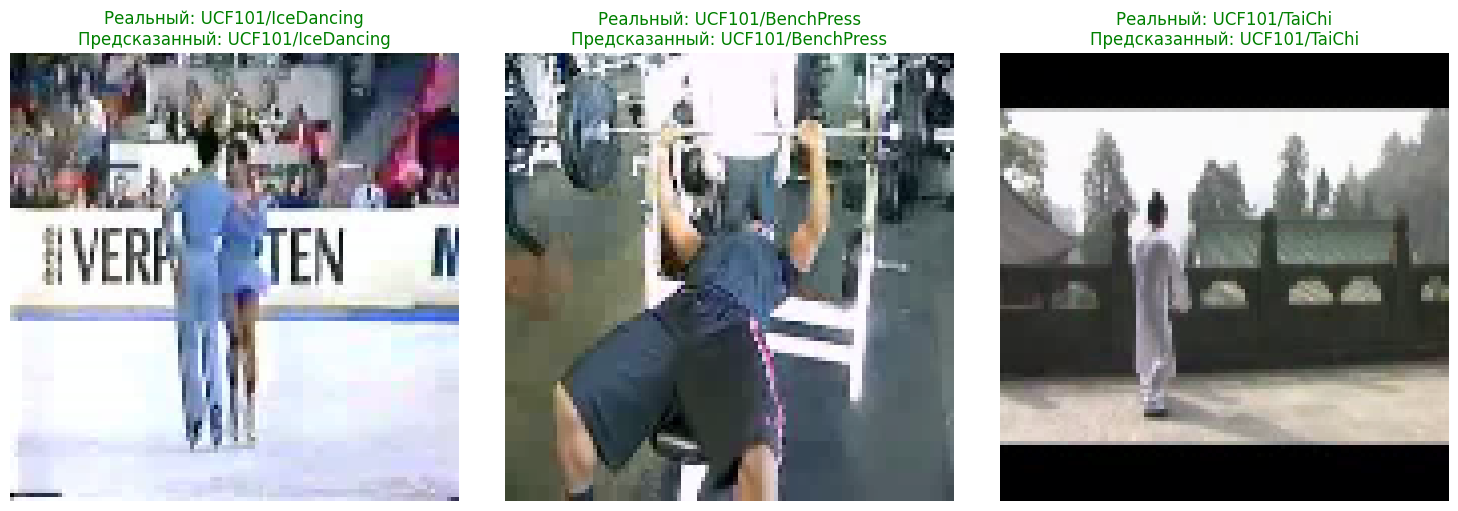

In [11]:
def visualize_predictions(model, dataset, num_examples=3):
    """Визуализация предсказаний модели"""
    model.eval()
    # Выбор случайных примеров
    indices = random.sample(range(len(dataset)), num_examples)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        clip, true_label = dataset[idx]
        # Подготовка клипа для модели
        clip = clip.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(clip.permute(0, 2, 1, 3, 4))
            _, pred_label = output.max(1)
        
        # Имена классов
        with zipfile.ZipFile(Config.DATA_PATH, 'r') as zip_ref:
            classes = sorted({os.path.dirname(f.filename) for f in zip_ref.infolist() if not f.is_dir()})
        true_class = classes[true_label]
        pred_class = classes[pred_label.item()]
        
        # Визуализация первого кадра клипа
        frame = clip[0, 0].cpu().permute(1, 2, 0).numpy()
        frame = (frame * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        frame = np.clip(frame, 0, 1)
        
        plt.subplot(1, num_examples, i+1)
        plt.imshow(frame)
        plt.title(f"Реальный: {true_class}\nПредсказанный: {pred_class}", color='green' if true_class == pred_class else 'red')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Загрузка модели
model = load_model()
model.load_state_dict(torch.load('best_model.pth'))

# Подготовка данных для визуализации
with zipfile.ZipFile(Config.DATA_PATH, 'r') as zip_ref:
    classes = sorted({os.path.dirname(f.filename) for f in zip_ref.infolist() if not f.is_dir()})
    class_to_idx = {cls: i for i, cls in enumerate(classes)}
    video_paths, labels = [], []
    for cls in classes:
        for f in zip_ref.infolist():
            if f.filename.startswith(cls + '/') and not f.is_dir():
                video_paths.append(f.filename)
                labels.append(class_to_idx[cls])

_, val_paths, _, val_labels = train_test_split(video_paths, labels, test_size=0.2, random_state=SEED)
val_dataset = Dataset(val_paths, val_labels)

# Визуализация
visualize_predictions(model, val_dataset)